In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Climate Analysis

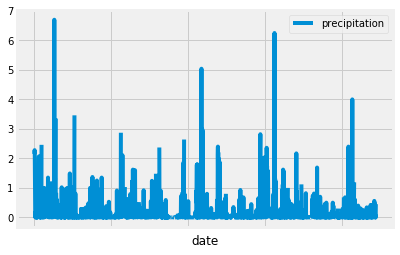

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastrecord = session.query(Measurement).order_by(Measurement.date.desc()).first()  #Retrieves most recent date
lastdate = dt.datetime.strptime(lastrecord.date, '%Y-%m-%d') #converts to datetime object lastdate
oneyear = dt.timedelta(365)   #Amount of days in a year - Doesn't take leap years into account.
firstdate = lastdate - oneyear

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
year_precip_df = pd.read_sql(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= firstdate).statement, session.bind,index_col='date') 
year_precip_df.rename(columns= {'prcp' : 'precipitation'}, inplace = True)
# Sort the dataframe by date
year_precip_df.sort_values(by='date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
year_precip_df.plot()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(year_precip_df['precipitation'].describe())

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).all()
print(f'Number of stations: {len(stations)}')
stations

Number of stations: 9


[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
stationcount_df = pd.read_sql(session.query(Measurement.station, func.count(Measurement.station).label('measurement count')).group_by(Measurement.station).statement,session.bind, index_col='station')
stationcount_df.sort_values(by='measurement count', ascending=False, inplace=True)
# List the stations and the counts in descending order.
print(stationcount_df)

             measurement count
station                       
USC00519281               2772
USC00519397               2724
USC00513117               2709
USC00519523               2669
USC00516128               2612
USC00514830               2202
USC00511918               1979
USC00517948               1372
USC00518838                511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = stationcount_df.index[0]
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).first()
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).first()
print("-"*50)
print(f"Most active station: {most_active}")
print(f"Highest temperature at station: {highest_temp[0]}° F")
print(f"Lowest temperature at station: {lowest_temp[0]}° F")
print(f"Average temperature at station: {round(avg_temp[0],2)}° F")
print("-"*50)

--------------------------------------------------
Most active station: USC00519281
Highest temperature at station: 85.0° F
Lowest temperature at station: 54.0° F
Average temperature at station: 71.66° F
--------------------------------------------------


USC00519281


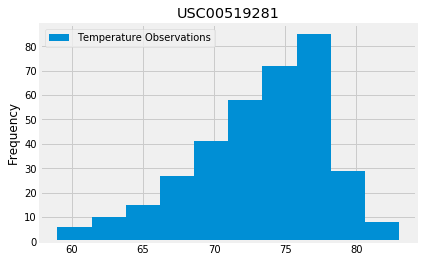

In [15]:
# Choose the station with the highest number of temperature observations.

##The most active station will be the same as the above, but for the sake of the exercise we'll repeat it.
most_tobs = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]
print(most_tobs)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temp_df = pd.read_sql(session.query(Measurement.date, Measurement.tobs.label('Temperature Observations')).filter(Measurement.date >= firstdate).filter(Measurement.station == most_tobs).statement, session.bind,index_col='date') 
year_temp_df.head()

year_temp_df.plot(kind='hist',title=most_tobs)

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripstart = '2017-08-05'
tripend = '2017-08-12'
trip_forecast=calc_temps(tripstart, tripend)[0]
print("-"*20)
print(f"Forecast for {tripstart} to {tripend}:")
print(f"High Temp: {trip_forecast[2]} \nLow Temp: {trip_forecast[0]} \nAvg Temp: {round(trip_forecast[1],2)}")
print("-"*20)

--------------------
Forecast for 2017-08-05 to 2017-08-12:
High Temp: 83.0 
Low Temp: 71.0 
Avg Temp: 79.37
--------------------


(0.0, 100)

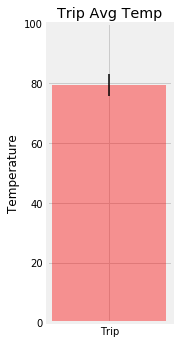

In [19]:
# Plot the results from your previous query as a bar chart. 

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_error=trip_forecast[2]-trip_forecast[1]
forecastfig = plt.figure(figsize=(2,5.5))
plt.bar("Trip",trip_forecast[1], yerr=trip_error, color='red', alpha=0.4, width=0.6, error_kw = {'elinewidth' : 1.5})
plt.ylabel("Temperature")
plt.title('Trip Avg Temp')
plt.ylim(top=100)
plt.xlim(-0.4,0.4)

In [20]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_precip_df = pd.read_sql(session.query(Measurement.prcp, Measurement.station, Station.name, Measurement.date, Station.latitude, Station.longitude, Station.elevation).join(Station, Measurement.station == Station.station).order_by(Measurement.prcp.desc()).statement, session.bind)
print(trip_precip_df.head())

    prcp      station                                    name        date  \
0  11.53  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  2014-07-20   
1   9.64  USC00519281                     WAIHEE 837.5, HI US  2016-07-25   
2   8.81  USC00519281                     WAIHEE 837.5, HI US  2011-01-13   
3   8.06  USC00516128            MANOA LYON ARBO 785.2, HI US  2013-11-10   
4   7.97  USC00519281                     WAIHEE 837.5, HI US  2014-07-20   

   latitude  longitude  elevation  
0  21.52130 -157.83740        7.0  
1  21.45167 -157.84889       32.9  
2  21.45167 -157.84889       32.9  
3  21.33310 -157.80250      152.4  
4  21.45167 -157.84889       32.9  


## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
tripstart_dt = dt.datetime.strptime(tripstart, '%Y-%m-%d')
tripend_dt = dt.datetime.strptime(tripend, '%Y-%m-%d')
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
dates_dt=[]
dates = []
checkdate_dt = tripstart_dt
while checkdate_dt <= tripend_dt:
    dates_dt.append(checkdate_dt)
    checkdate_dt += dt.timedelta(days=1)
    dates.append(checkdate_dt.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in dates:
    normals.append(daily_normals(date)[0])
print(dates)
print(dates_dt)
print(normals)

['08-06', '08-07', '08-08', '08-09', '08-10', '08-11', '08-12', '08-13']
[datetime.datetime(2017, 8, 5, 0, 0), datetime.datetime(2017, 8, 6, 0, 0), datetime.datetime(2017, 8, 7, 0, 0), datetime.datetime(2017, 8, 8, 0, 0), datetime.datetime(2017, 8, 9, 0, 0), datetime.datetime(2017, 8, 10, 0, 0), datetime.datetime(2017, 8, 11, 0, 0), datetime.datetime(2017, 8, 12, 0, 0)]
[(67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0), (68.0, 76.5576923076923, 83.0), (69.0, 75.98039215686275, 81.0), (65.0, 76.42, 83.0), (67.0, 75.98113207547169, 82.0), (67.0, 76.52727272727273, 83.0), (71.0, 76.98245614035088, 84.0)]


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_precip_df = pd.DataFrame(normals, columns=['TMIN','TAVG','TMAX'], index=dates)
trip_precip_df.index.name='Date'
trip_precip_df.head()

,TMIN,TAVG,TMAX
Date,,,
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0
08-09,69.0,75.980392,81.0
08-10,65.0,76.420000,83.0


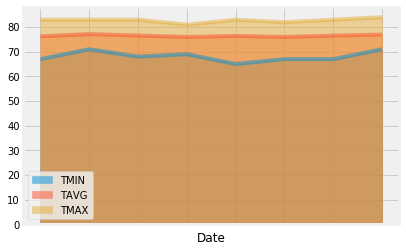

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
trip_precip_df.plot(kind='area', stacked=False)